# Sentinel-2 multiclass classification using Convolutional Neural Network

## Download the EuroSAT dataset


[EuroSAT dataset](https://github.com/phelber/EuroSAT)
![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)


Download the dataset

In [1]:
import requests

url =  'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
r = requests.get(url, allow_redirects=True)
open('EuroSAT.zip', 'wb').write(r.content)

94280567

Unzip the dataset

In [ ]:
!unzip '/content/EuroSAT.zip'

Rename the folder

In [3]:
!mv '/content/2750' '/content/EuroSAT'

Count images in the dataset

In [4]:
import glob

paths = glob.glob('/content/EuroSAT/*/*')
print('Number of images {}/27000'.format(len(paths)))

Number of images 27000/27000


## Image Data Generator 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(64, 64),  
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(64, 64),  
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [6]:
classes = train_generator.class_indices
classes= dict(zip(classes.values(), classes.keys()))  
print(classes)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


Generate some exaples

In [7]:
x,y = next(iter(train_generator))
print('x shape {}'.format(x.shape))
print('y shape {}'.format(y.shape))

x shape (16, 64, 64, 3)
y shape (16, 10)


Plot some examples

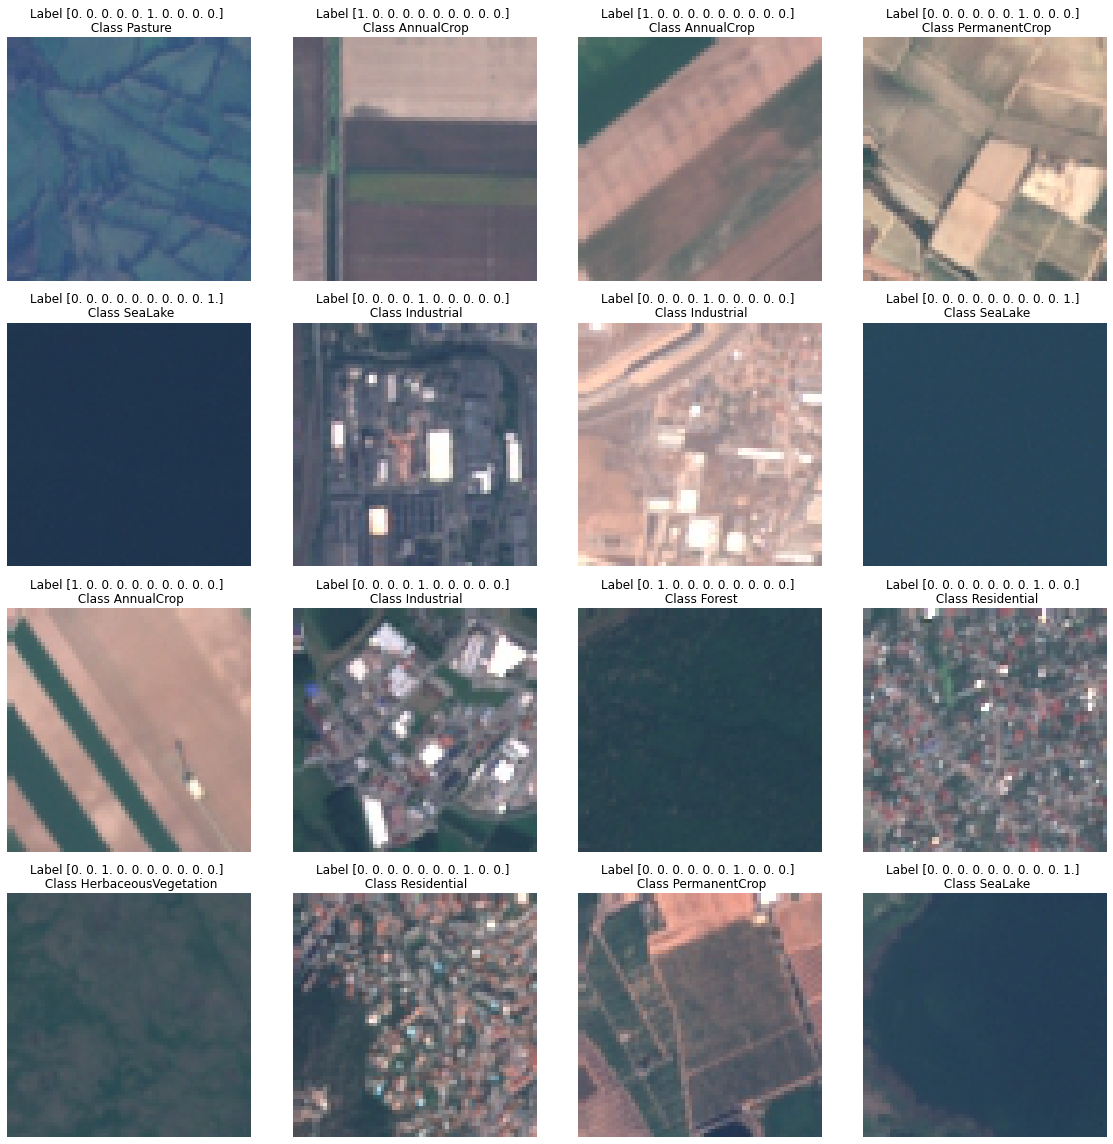

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16,16))

ct = 0
for i in range(4):
  for j in range(4):
    axes[i,j].imshow(x[ct])
    axes[i,j].set_title('Label {} \n Class {}'.format(y[ct], classes[np.argmax(y[ct])]))
    axes[i,j].axis(False)
    ct += 1

fig.tight_layout()
plt.show()


## Define the Convolutional Neural Network

We will use the LeNet-5 ([Find out more](https://en.wikipedia.org/wiki/LeNet))

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, Dropout


model = None
x_in = Input(shape = (64,64,3))


# Convolution
x = Conv2D(filters=6, kernel_size=(5, 5), activation='relu')(x_in)
x = AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(x)
x = AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)
# MLP
x = Flatten()(x)
x = Dense(units=120, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=84, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=10, activation = 'softmax')(x)

model = Model(inputs = x_in, outputs = x)

Compile the model

In [29]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Print model configuration

In [30]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 6)         456       
                                                                 
 average_pooling2d_6 (Averag  (None, 30, 30, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 13, 13, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 2704)              0   

## Train the LeNet-5

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//batch_size,
    epochs = 15
)

Epoch 1/15
1350/1350 [==============================] - 16s 11ms/step - loss: 1.6267 - accuracy: 0.3667 - val_loss: 1.1304 - val_accuracy: 0.6083
Epoch 2/15
1350/1350 [==============================] - 14s 11ms/step - loss: 1.1240 - accuracy: 0.5875 - val_loss: 0.9120 - val_accuracy: 0.6736
Epoch 3/15
1350/1350 [==============================] - 14s 11ms/step - loss: 0.9481 - accuracy: 0.6612 - val_loss: 0.9860 - val_accuracy: 0.6428
Epoch 4/15
1350/1350 [==============================] - 15s 11ms/step - loss: 0.8547 - accuracy: 0.6972 - val_loss: 0.7776 - val_accuracy: 0.7268
Epoch 5/15
1350/1350 [==============================] - 14s 11ms/step - loss: 0.7789 - accuracy: 0.7284 - val_loss: 0.7435 - val_accuracy: 0.7402
Epoch 6/15
1350/1350 [==============================] - 14s 11ms/step - loss: 0.6995 - accuracy: 0.7540 - val_loss: 0.7445 - val_accuracy: 0.7404
Epoch 7/15
1350/1350 [==============================] - 14s 11ms/step - loss: 0.6526 - accuracy: 0.7695 - val_loss: 0.7634 -

Plot training history

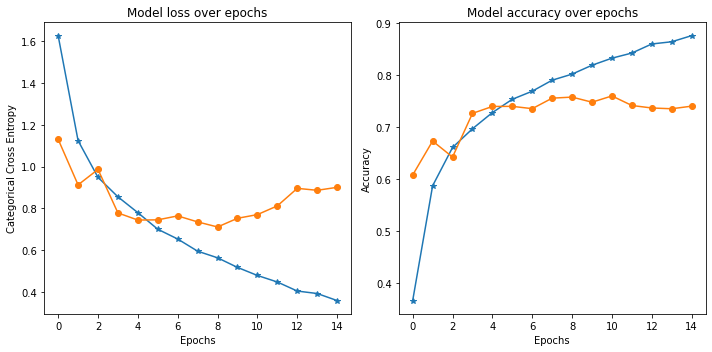

In [34]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

axes[0].plot(history.history['loss'], '-*', label = 'Training')
axes[0].plot(history.history['val_loss'], '-o', label = 'Validtion')
axes[0].set_ylabel('Categorical Cross Entropy')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Model loss over epochs')

axes[1].plot(history.history['accuracy'], '-*', label = 'Training')
axes[1].plot(history.history['val_accuracy'], '-o', label = 'Validtion')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Model accuracy over epochs')

fig.tight_layout()
plt.show()

## Evaluate Performances

In [44]:
batch_size = val_generator.n

val_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(64, 64),  
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') 

Found 5400 images belonging to 10 classes.


Get predictions for the validation set

In [47]:
x, y = next(iter(val_generator))
y_true = np.argmax(y, axis=1)
Y_pred = model.predict(x)
y_pred = np.argmax(Y_pred, axis=1)

Compute confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')

Plot confusion matrix

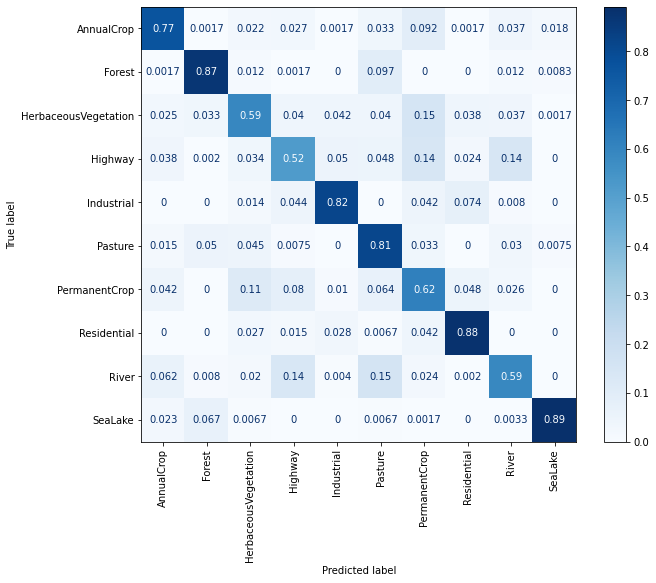

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.values())
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

Compute classification report

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes.values()))

                      precision    recall  f1-score   support

          AnnualCrop       0.81      0.77      0.79       600
              Forest       0.86      0.87      0.86       600
HerbaceousVegetation       0.70      0.59      0.64       600
             Highway       0.59      0.52      0.55       500
          Industrial       0.85      0.82      0.83       500
             Pasture       0.57      0.81      0.67       400
       PermanentCrop       0.52      0.62      0.56       500
         Residential       0.84      0.88      0.86       600
               River       0.66      0.59      0.62       500
             SeaLake       0.96      0.89      0.93       600

            accuracy                           0.74      5400
           macro avg       0.74      0.74      0.73      5400
        weighted avg       0.75      0.74      0.74      5400

